<img src='images/slide3.png'>

<img src='images/slide4.png'>

> https://github.com/maciejkula/netrex

<img src='images/slide4b.png'>

<img src='images/slide5.png'>

# Load Data

In [3]:
import os
import pandas as pd

In [20]:
ratings_table = pd.read_csv('./data/ratings.csv', 
                      sep='\t', index_col=[0])
num_users = ratings_table['userid'].max()
num_items = ratings_table['movieid'].max()
ratings_table = ratings_table.drop('timestamp', 1)

In [22]:
ratings_table.head()

,userid,movieid,rating,user_emb_id,movie_emb_id
0,1,1193,5,0,1192
1,1,661,3,0,660
2,1,914,3,0,913
3,1,3408,4,0,3407
4,1,2355,5,0,2354


> Because data is sorted by **userid** need to shuffle it 

In [37]:
shuffled_ratings = ratings_table.sample(frac=1., random_state=12345)
users = shuffled_ratings['user_emb_id'].values
items = shuffled_ratings['movie_emb_id'].values
ratings = shuffled_ratings['rating'].values

# Model

In [32]:
import numpy as np
from keras.layers import Embedding, Reshape, Dropout, Dense, Merge, Input, Flatten, merge
from keras.models import Sequential
from keras.models import Model
from keras.callbacks import Callback, EarlyStopping, ModelCheckpoint
import math
import matplotlib.pyplot as plt
%matplotlib inline

In [27]:
embeddings_size = 100

In [31]:
U = Sequential()
U.add(Embedding(num_users, embeddings_size, input_length=1))
U.add(Reshape((embeddings_size,)))
I = Sequential()
I.add(Embedding(num_items, embeddings_size, input_length=1))
I.add(Reshape((embeddings_size,)))
M = Sequential()
M.add(Merge([U, I], mode='dot', dot_axes=1))
M.compile(loss='mean_squared_error', optimizer='adam')

/Users/jaimealmeida/anaconda/envs/dl/lib/python3.6/site-packages/ipykernel/__main__.py:8: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.


> Interesting discussion about issue: https://github.com/fchollet/keras/issues/1675 . Nonetheless, replacing  layer `Merge([], mode="dot")` with `keras.layers.merge.dot` produces a far worse error when `Sequential models` are the input. 

In [36]:
callbacks = [EarlyStopping('val_loss', patience=2), 
             ModelCheckpoint('./data/weights.h5', save_best_only=True)]
history = M.fit([users, items], 
                    ratings, 
                    epochs=20, 
                    validation_split=.1, 
                    callbacks=callbacks)

Train on 900188 samples, validate on 100021 samples
Epoch 1/20
900188/900188 [==============================] - 376s - loss: 1.3340 - val_loss: 0.8905
Epoch 2/20
900188/900188 [==============================] - 377s - loss: 0.7945 - val_loss: 0.8452
Epoch 3/20
900188/900188 [==============================] - 384s - loss: 0.6470 - val_loss: 0.8621
Epoch 4/20
900188/900188 [==============================] - 385s - loss: 0.5292 - val_loss: 0.9056
Epoch 5/20
900188/900188 [==============================] - 371s - loss: 0.4516 - val_loss: 0.9606


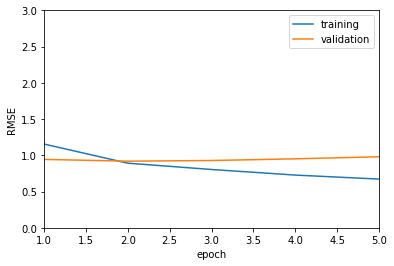

In [52]:
results = pd.DataFrame({'epoch': [ i + 1 for i in history.epoch ],
                     'training': [ math.sqrt(loss) for loss in history.history['loss'] ],
                     'validation': [ math.sqrt(loss) for loss in history.history['val_loss'] ]})
ax = results.ix[:,:].plot(x='epoch')
ax.set_ylabel("RMSE")
ax.set_ylim([0.0,3.0]);

> After the second epoch the model started overfitting. I will try to use a `Dropout` layer and a different optimizer to see if this helps.

## Adding dropout

In [55]:
U2 = Sequential()
U2.add(Embedding(num_users, embeddings_size, input_length=1))
U2.add(Reshape((embeddings_size,)))
I2 = Sequential()
I2.add(Embedding(num_items, embeddings_size, input_length=1))
I2.add(Reshape((embeddings_size,)))
M2 = Sequential()
M2.add(Merge([U2, I2], mode='dot', dot_axes=1))
M2.add(Dropout(0.2))
M2.add(Dense(1, activation='linear'))
M2.compile(loss='mean_squared_error', optimizer='adamax')

/Users/jaimealmeida/anaconda/envs/dl/lib/python3.6/site-packages/ipykernel/__main__.py:8: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.


In [53]:
callbacks = [EarlyStopping('val_loss', patience=2), 
             ModelCheckpoint('./data/M2weights.h5', save_best_only=True)]
history2 = M2.fit([users, items], 
                  ratings,
                  epochs=20, 
                  validation_split=.1, 
                  callbacks=callbacks)

Train on 900188 samples, validate on 100021 samples
Epoch 1/20
900188/900188 [==============================] - 347s - loss: 0.3932 - val_loss: 0.9522
Epoch 2/20
900188/900188 [==============================] - 362s - loss: 0.3843 - val_loss: 0.9666
Epoch 3/20
900188/900188 [==============================] - 351s - loss: 0.3757 - val_loss: 0.9756
Epoch 4/20
900188/900188 [==============================] - 361s - loss: 0.3674 - val_loss: 0.9869


> No improvement in performance, hence keep the former model.

<img src='images/slide6.png'>

In [12]:
import os
import scipy.sparse as sp
import pandas as pd
import numpy as np
from keras import backend as K
from keras.optimizers import Adam
from sklearn.metrics import roc_auc_score

In [8]:
ratings_table = pd.read_csv('./data/ratings.csv', 
                      sep='\t', index_col=[0])
num_users = ratings_table['userid'].max()
num_items = ratings_table['movieid'].max()
ratings_table = ratings_table.drop('timestamp', 1)

In [9]:
ratings_table.head()

,userid,movieid,rating,user_emb_id,movie_emb_id
0,1,1193,5,0,1192
1,1,661,3,0,660
2,1,914,3,0,913
3,1,3408,4,0,3407
4,1,2355,5,0,2354


In [10]:
r = ratings_table[['userid', 'movieid', 'rating']]

In [13]:
# splitting table on train/test
msk = np.random.rand(len(r)) < 0.8
train = r[msk]
test = r[~msk]

In [15]:
# this is needed because movies and items are 1-indexed
num_users = r['userid'].max() + 1
num_items = r['movieid'].max() + 1

In [16]:
def build_interaction_matrix(rows, cols, data):
''' This method build a sparse matrix where ratings greater or equal
to 4 are marked as 1 and all others are zero'''
    mat = sp.lil_matrix((rows, cols))
    for index, row in data.iterrows():
        if row["rating"] >= 4.0:
            mat[row['userid'], row['movieid']] = 1.0
    return mat.tocoo()

In [17]:
train_interaction = build_interaction_matrix(num_users, num_items, train)
test_interaction = build_interaction_matrix(num_users, num_items, test)

In [18]:
train.head()

,userid,movieid,rating
0,1,1193,5
1,1,661,3
2,1,914,3
3,1,3408,4
6,1,1287,5


In [19]:
# source code using Theano backend
# https://github.com/maciejkula/triplet_recommendations_keras/blob/master/triplet_movielens.py
def get_triplets(mat):
    '''Method '''
    return mat.row, mat.col, np.random.randint(mat.shape[1], size=len(mat.row))

In [20]:
def identity_loss(y_true, y_pred):
    return K.mean(y_pred - 0 * y_true)

In [21]:
# Bayesian Personalized Ranking loss
# https://pdfs.semanticscholar.org/1c2c/ae04e0e00dcec3fe6840b2daa00ae9e8a0a3.pdf

def bpr_triplet_loss(X):
''' Implementation of Bayesian Personalized Ranking loss where 
the objective is to rate positive items higher'''

    positive_item_latent, negative_item_latent, user_latent = X

    loss = 1.0 - K.sigmoid(
        K.sum(user_latent * positive_item_latent, axis=-1, keepdims=True) -
        K.sum(user_latent * negative_item_latent, axis=-1, keepdims=True))

    return loss

In [22]:
# Size of the embeddings
latent_dim = 100

In [27]:
positive_item_input = Input((1, ), name='positive_item_input')
negative_item_input = Input((1, ), name='negative_item_input')

# Shared embedding layer for positive and negative items
item_embedding_layer = Embedding(
    num_items, latent_dim, name='item_embedding', input_length=1)

user_input = Input((1, ), name='user_input')

# this makes sure that weights are shared
positive_item_embedding = Flatten()(item_embedding_layer(
    positive_item_input))
negative_item_embedding = Flatten()(item_embedding_layer(
    negative_item_input))
user_embedding = Flatten()(Embedding(
    num_users, latent_dim, name='user_embedding', input_length=1)(
    user_input))

In [30]:
loss = merge(
        [positive_item_embedding, negative_item_embedding, user_embedding],
        mode=bpr_triplet_loss,
        name='loss',
        output_shape=(1, ))

/Users/jaimealmeida/anaconda/envs/dl/lib/python3.6/site-packages/ipykernel/__main__.py:5: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
/Users/jaimealmeida/anaconda/envs/dl/lib/python3.6/site-packages/keras/legacy/layers.py:456: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  name=name)


In [33]:
model = Model(
    input=[positive_item_input, negative_item_input, user_input], 
    output=loss)

/Users/jaimealmeida/anaconda/envs/dl/lib/python3.6/site-packages/ipykernel/__main__.py:3: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("lo...)`
  app.launch_new_instance()


In [34]:
model.compile(loss=identity_loss, optimizer="adam")

In [35]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
positive_item_input (InputLayer) (None, 1)             0                                            
____________________________________________________________________________________________________
negative_item_input (InputLayer) (None, 1)             0                                            
____________________________________________________________________________________________________
user_input (InputLayer)          (None, 1)             0                                            
____________________________________________________________________________________________________
item_embedding (Embedding)       (None, 1, 100)        395300                                       
___________________________________________________________________________________________

+ As problem is reframed to **binary classification** there is the need to evaluate its results accordingly. RMSE as used in the first model is no longer relevant.

In [36]:
def full_auc(model, ground_truth):
    """
    Measure AUC for model and ground truth on all items.

    Returns:
    - float AUC
    """

    ground_truth = ground_truth.tocsr()
#     print(ground_truth)

    no_users, no_items = ground_truth.shape
#     print(no_users, no_items)

    pid_array = np.arange(no_items, dtype=np.int32)

    scores = []

    for user_id, row in enumerate(ground_truth):

        predictions = predict(model, user_id, pid_array)
#         print(predictions)
#         print("row data", row.data)
#         print("row")
#         print(row)

        true_pids = row.indices[row.data == 1]
#         print(true_pids)

        grnd = np.zeros(no_items, dtype=np.int32)
        grnd[true_pids] = 1
        grnd

        if len(true_pids):
            sc = roc_auc_score(grnd, predictions)
#             print("sc", sc)
            scores.append(sc)

    return sum(scores) / len(scores)

In [37]:
def predict(model, uid, pids):
''' Prediction is obtained by dotting the weights of the user and items'''
    user_vector = model.get_layer('user_embedding').get_weights()[0][uid]
    item_matrix = model.get_layer('item_embedding').get_weights()[0][pids]

    scores = (np.dot(user_vector,
                     item_matrix.T))

    return scores

In [38]:
# The expected initial value is 0.5
print('AUC before training %s' % full_auc(model, test_interaction))

AUC before training 0.501489089637


In [39]:
num_epochs = 10

In [40]:
for epoch in range(num_epochs):

    print('Epoch %s' % epoch)

    # Sample triplets from the training data
    uid, pid, nid = get_triplets(train_interaction)

    X = {
        'user_input': uid,
        'positive_item_input': pid,
        'negative_item_input': nid
    }

    model.fit(X,
              np.ones(len(uid)),
              batch_size=64,
              epochs=1,
              verbose=0,
              shuffle=True)

    print('AUC %s' % full_auc(model, test_interaction))

Epoch 0
AUC 0.882614821951
Epoch 1
AUC 0.890137827732
Epoch 2
AUC 0.898631976608
Epoch 3
AUC 0.904835006503
Epoch 4
AUC 0.910156371983
Epoch 5
AUC 0.914453605606
Epoch 6
AUC 0.91771299387
Epoch 7
AUC 0.920173463188
Epoch 8
AUC 0.922038165003
Epoch 9
AUC 0.92361321141
